In [ ]:


# --- Imports
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp

# --- Config / inputs
STRING_TSV = 'STRING_edges_0p6.tsv'   # local STRING edges 
CPM_THRESH = 1.0                      # presence threshold for binarization (CPM >= 1)


new_labels = [
    "CD4+ T",         # cluster 0
    "CD14+",          # cluster 1
    "B",              # cluster 2
    "CD8+ T",         # cluster 3
    "FCGR3A+",        # cluster 4
    "NK",             # cluster 5
    "Dendritic",      # cluster 6
    "Megakaryocytes"  # cluster 7
]


adata = sc.datasets.pbmc3k()
X = adata.X.A if sp.issparse(adata.X) else adata.X
lib = X.sum(axis=1, keepdims=True); lib[lib == 0] = 1
CPM = (X / lib) * 1e6

genes_all = np.array(adata.var_names).astype(str)
present_frac = (CPM >= CPM_THRESH).mean(axis=0)

# drop housekeeping to reduce noise
def is_hk(g):
    u = g.upper()
    return u.startswith('RPL') or u.startswith('RPS') or u.startswith('MT-') \
        or u in {'MALAT1','FTL','FTH1'} or u.startswith('HSP') or u.startswith('TMSB')

mask_hk = np.array([not is_hk(g) for g in genes_all])

# Load STRING PPI (local TSV) and normalize columns
import pandas as pd

def parse_string_tsv(tsv_path, a_hint=None, b_hint=None, score_hint=None):
    df_raw = pd.read_csv(tsv_path, sep=None, engine='python')
    cols_lower = {c.lower(): c for c in df_raw.columns}

    def pick(hint, candidates):
        if hint and hint in df_raw.columns:
            return hint
        for c in candidates:
            if c in cols_lower:
                return cols_lower[c]
        return None

    candA = [
        'genea','preferredname_a','preferrednamea',
        'stringid_a','protein1','node1','item_id_a','protein a','node a',
        '#node1','a'   # <-- accept plain 'A'
    ]
    candB = [
        'geneb','preferredname_b','preferrednameb',
        'stringid_b','protein2','node2','item_id_b','protein b','node b',
        '#node2','b'   # <-- accept plain 'B'
    ]
    candS = ['score','combined_score','combined score','combinedscore']

    colA = pick(a_hint, candA)
    colB = pick(b_hint, candB)
    colS = pick(score_hint, candS)

    if colA is None or colB is None:
        print("Columns present:", list(df_raw.columns))
        raise ValueError('STRING TSV must have endpoint columns.')

    df = df_raw.rename(columns={colA: 'geneA', colB: 'geneB'})
    if colS is not None:
        s = df_raw[colS]
        if colS.lower().replace(' ', '_') == 'combined_score':
            s = s / 1000.0
        df['score'] = s
    else:
        df['score'] = 1.0

    df['geneA'] = df['geneA'].astype(str).str.strip().str.upper()
    df['geneB'] = df['geneB'].astype(str).str.strip().str.upper()
    df = df[df['geneA'].notna() & df['geneB'].notna()]
    df = df[df['geneA'] != df['geneB']].drop_duplicates()

    return df[['geneA','geneB','score']]


ppi = parse_string_tsv(STRING_TSV)
#  adjust to the exact column names your file shows
ppi = parse_string_tsv('STRING_edges_0p6.tsv',
                       a_hint='preferredName_A',
                       b_hint='preferredName_B',
                       score_hint='score')  # or 'combined_score'

ppi_nodes = set(ppi['geneA']) | set(ppi['geneB'])

# INTERSECTION: PBMC3k ∩ STRING ∩ expressed (>=10% cells) ∩ non-housekeeping
mask_ppi  = np.array([g.upper() in ppi_nodes for g in genes_all])
mask_expr = present_frac >= 0.10
keep_mask = mask_ppi & mask_expr & mask_hk

genes_use = genes_all[keep_mask]
genes_use_upper = np.array([g.upper() for g in genes_use])
B = (CPM[:, keep_mask] >= CPM_THRESH).astype(np.uint8)   # binary presence

print(f"Universe → {len(genes_use)} genes (from {len(genes_all)}).")

#  Build adjacency on kept genes
idx_map = {g:i for i,g in enumerate(genes_use_upper)}
edges = [(idx_map[a], idx_map[b]) for a,b in ppi[['geneA','geneB']].itertuples(index=False)
         if a in idx_map and b in idx_map and a != b]

n = len(genes_use)
adj = [[] for _ in range(n)]
for u,v in edges:
    adj[u].append(v); adj[v].append(u)
deg = np.array([len(adj[i]) for i in range(n)], dtype=int)
print("Adjacency:", n, "nodes;", len(edges), "edges.")

# scoring
def microarray_shapley(B_bool: np.ndarray) -> np.ndarray:
    M = B_bool.sum(axis=1, keepdims=True)
    M[M == 0] = 1
    Rij = np.where(B_bool == 1, 1.0/M, 0.0)
    return Rij.sum(axis=0) / B_bool.shape[0]

def neighborhood_shapley(k: np.ndarray) -> np.ndarray:
    out = np.zeros(n, dtype=float)
    w = k / (deg + 1.0)
    for i in range(n):
        s = w[i]
        for j in adj[i]:
            s += w[j]
        out[i] = s
    return out

# Clustering (Leiden) 
if 'leiden' not in adata.obs.columns:
    ad_tmp = adata.copy()
    sc.pp.normalize_total(ad_tmp, target_sum=1e4); sc.pp.log1p(ad_tmp)
    sc.pp.highly_variable_genes(ad_tmp, n_top_genes=2000, flavor='seurat_v3')
    ad_tmp = ad_tmp[:, ad_tmp.var['highly_variable']]
    sc.pp.scale(ad_tmp, max_value=10); sc.tl.pca(ad_tmp, n_comps=50)
    sc.pp.neighbors(ad_tmp, n_neighbors=15, n_pcs=50); sc.tl.leiden(ad_tmp, resolution=0.6)
    adata.obs['leiden'] = ad_tmp.obs['leiden'].values

# Δ markers per cluster (cluster vs rest), top-5 each
clusters = sorted(adata.obs['leiden'].astype(str).unique(), key=lambda x: int(x))
records = []
for c in clusters:
    mask_cells = (adata.obs['leiden'].astype(str).values == c)
    B_c, B_r = B[mask_cells], B[~mask_cells]

    k_c    = microarray_shapley(B_c) if B_c.shape[0] else np.zeros(n)
    k_rest = microarray_shapley(B_r) if B_r.shape[0] else np.zeros(n)

    phi_c  = neighborhood_shapley(k_c)
    phi_r  = neighborhood_shapley(k_rest)
    delta  = np.abs(phi_c - phi_r)

    top = pd.Series(delta, index=genes_use).sort_values(ascending=False).head(5)
    for rank, (g, s) in enumerate(top.items(), start=1):
        records.append({'cluster': f'cluster_{c}', 'gene': g, 'rank': rank})

df_long = pd.DataFrame(records).sort_values(['cluster','rank']).reset_index(drop=True)
df_wide = df_long.pivot_table(index='cluster', columns='rank', values='gene', aggfunc='first')
df_wide.columns = [f'top{r}' for r in df_wide.columns]
df_wide = df_wide.reset_index()


idx_to_name = {f"cluster_{i}": new_labels[i] for i in range(len(new_labels))}
df_named = df_wide.copy()
df_named['cluster'] = df_named['cluster'].map(idx_to_name).fillna(df_named['cluster'])
df_named = df_named.sort_values('cluster').reset_index(drop=True)

display(df_named)
df_named.to_csv('top5_markers_per_cluster_named_final.csv', index=False)
print('Saved: top5_markers_per_cluster_named_final.csv')


Universe → 1330 genes (from 32738).
Adjacency: 1330 nodes; 627 edges.


c:\Users\setia\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\setia\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\setia\AppData\Local\Temp\ipykernel_16840\1131737574.py:150: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.pp.neighbors(ad_tmp, n_neighbors=15, n_pcs=50); sc.tl.leiden(ad_tmp, resolution=0.6)


,cluster,top1,top2,top3,top4,top5
0,B,S100A8,S100A9,FCN1,AIF1,PTPRCAP
1,CD14+,CD7,CD3G,CD3D,CD3E,NOSIP
2,CD4+ T,CD2,AQP3,CD3D,CD3G,CD3E
3,CD8+ T,CD79B,HLA-DMA,HLA-B,HLA-F,HLA-E
4,Dendritic,GZMB,PRF1,SRGN,VIM,CD7
5,FCGR3A+,GZMA,GZMK,LYAR,NXT1,CST7
6,Megakaryocytes,PTPRCAP,EEF1A1,H3F3B,PFN1,CD3G
7,NK,PTPRCAP,CD68,TIMP1,CFD,RHOC


Saved: top5_markers_per_cluster_named_final.csv


In [ ]:
import json

#  Marker panels 
PANELS = {
    "B": {"MS4A1","CD79A","CD79B","BANK1","HVCN1","CD74"},
    "CD14+": {"S100A8","S100A9","FCN1","LGALS2","LYZ","AIF1","CTSS","TYROBP","LST1"},
    "FCGR3A+": {"FCGR3A","MS4A7","LILRB2","CX3CR1","CTSS","TYROBP"},
    "Dendritic": {"FCER1A","CST3","CLEC10A","ITGAX"},
    "NK": {"GNLY","NKG7","GZMB","PRF1","KLRD1","SPON2"},
    "CD8+ T": {"CD8A","CD8B","GZMA","GZMK","GZMB","PRF1","CTSW"},
    "CD4+ T": {"IL7R","CCR7","S100A4","LTB","IL32","TRAT1"},
    "Pan-T": {"CD3D","CD3E","CD3G","CD2","CD7","TRAC"},
}

# Make sure we know clusters, and build df_long/df_wide if absent
if 'leiden' not in adata.obs.columns:
    raise RuntimeError("Need adata.obs['leiden'] (run clustering first).")

if 'df_long' not in globals() or 'df_wide' not in globals():
    # Build per-cluster Δ ranks (top 50) on the current intersection universe
    def delta_for_mask(mask_cells):
        B_c, B_r = B[mask_cells], B[~mask_cells]
        k_c    = microarray_shapley(B_c) if B_c.shape[0] else np.zeros(len(genes_use))
        k_rest = microarray_shapley(B_r) if B_r.shape[0] else np.zeros(len(genes_use))
        return np.abs(neighborhood_shapley(k_c) - neighborhood_shapley(k_rest))

    rec = []
    for c in sorted(adata.obs['leiden'].astype(str).unique(), key=int):
        m = (adata.obs['leiden'].astype(str).values == c)
        d = delta_for_mask(m)
        s = pd.Series(d, index=genes_use).sort_values(ascending=False).head(50)
        for r,(g,val) in enumerate(s.items(), start=1):
            rec.append({'cluster': f'cluster_{c}', 'gene': g, 'rank': r, 'delta': float(val)})
    df_long = pd.DataFrame(rec)
    df_wide = (df_long[df_long['rank']<=5]
               .pivot_table(index='cluster', columns='rank', values='gene', aggfunc='first')
               .rename(columns=lambda r: f'top{r}')
               .reset_index())

# (CPM >= 1) on full adata
X = adata.X.A if sp.issparse(adata.X) else adata.X
lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
CPM = (X / lib) * 1e6
genes_all = np.array(adata.var_names).astype(str)
genes_upper = np.array([g.upper() for g in genes_all])
present = (CPM >= 1.0)


clus_masks = {f'cluster_{c}': (adata.obs['leiden'].astype(str).values == c)
              for c in adata.obs['leiden'].astype(str).unique()}

def frac_present_in_cluster(mask, gene_syms_upper):
    idx = [np.where(genes_upper == g)[0][0] for g in gene_syms_upper if g in genes_upper]
    if not idx: return 0.0, 0.0
    return float(present[mask][:, idx].mean()), float(present[~mask][:, idx].mean())

#  Build top-50 lists per cluster (uppercase)
topN = 50
per_cluster_lists = {}
for cl in df_long['cluster'].unique():
    tops = (df_long[df_long['cluster'].eq(cl)]
            .sort_values('rank')['gene'].head(topN).tolist())
    per_cluster_lists[cl] = [str(g).upper() for g in tops]

#  Score clusters against panels (votes + expression support)
def score_cluster(cluster_label, tops_upper):
    mask = clus_masks[cluster_label]
    scores = {}
    for name, panel in PANELS.items():
        votes = len(set(tops_upper) & panel)
        frac_c, frac_r = frac_present_in_cluster(mask, list(panel))
        support = max(frac_c - frac_r, 0.0)
        scores[name] = votes + 3.0*support  # small weight for expression specificity
    # NK vs T disambiguation: if Pan-T present, prefer T flavors
    if scores.get("NK",0) == max(scores.values()) and scores.get("Pan-T",0) > 0:
        scores["NK"] = scores["NK"] - 0.25  # nudge away if clear T signature
    return scores

cluster_name_map = {}
for cl, tops in per_cluster_lists.items():
    scs = score_cluster(cl, tops)
    # pick best label, but collapse dendritic vs FCGR3A+ if needed
    best = max(scs, key=scs.get)
    if best == "Dendritic" and scs.get("FCGR3A+",0) > scs["Dendritic"]:
        best = "FCGR3A+"
    if best == "Pan-T":  # refine Pan-T to CD4+ or CD8+ if signal says so
        best = "CD8+ T" if scs.get("CD8+ T",0) >= scs.get("CD4+ T",0) else "CD4+ T"
    cluster_name_map[cl] = best

# Freeze names
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['cluster_name'] = adata.obs['leiden'].map(lambda x: cluster_name_map.get(f'cluster_{x}', f'cluster_{x}'))
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')

df_named = df_wide.copy()
df_named['cluster'] = df_named['cluster'].map(lambda x: cluster_name_map.get(x, x))
df_named = df_named.sort_values('cluster').reset_index(drop=True)

# save the mapping
with open('cluster_name_map.json','w') as f:
    json.dump(cluster_name_map, f, indent=2)

display(df_named)
df_named.to_csv('top5_markers_per_cluster_named_consensus.csv', index=False)
print("Saved: top5_markers_per_cluster_named_consensus.csv and cluster_name_map.json")


,cluster,top1,top2,top3,top4,top5
0,B,CD79B,HLA-DMA,HLA-B,HLA-F,HLA-E
1,CD14+,S100A8,S100A9,FCN1,AIF1,PTPRCAP
2,CD4+ T,CD2,AQP3,CD3D,CD3G,CD3E
3,CD4+ T,CD7,CD3G,CD3D,CD3E,NOSIP
4,CD8+ T,GZMA,GZMK,LYAR,NXT1,CST7
5,Dendritic,PTPRCAP,EEF1A1,H3F3B,PFN1,CD3G
6,FCGR3A+,PTPRCAP,CD68,TIMP1,CFD,RHOC
7,NK,GZMB,PRF1,SRGN,VIM,CD7


Saved: top5_markers_per_cluster_named_consensus.csv and cluster_name_map.json


In [ ]:

# Build a mapping from cluster id to original human-readable name 
if 'new_labels' in globals() and len(new_labels) >= adata.obs['leiden'].nunique():
    orig_map = {f"cluster_{i}": new_labels[i] for i in range(len(new_labels))}
else:
    orig_map = {c: c for c in df_wide['cluster'].unique()}

#  Consensus names from the auto-naming 
cons_map = dict(cluster_name_map)  

# Make a final table with BOTH names + numeric id + top1 to top5
df_final = df_wide.copy()

# numeric id for traceability
df_final.insert(1, 'cluster_id', df_final['cluster'].str.replace('cluster_', '', regex=False).astype(int))

# original name
df_final.insert(2, 'cluster_original', df_final['cluster'].map(orig_map))

# consensus name (from marker-based naming)
df_final.insert(3, 'cluster_consensus', df_final['cluster'].map(lambda x: cons_map.get(x, orig_map.get(x, x))))

# tidy ordering
cols = ['cluster_id', 'cluster_original', 'cluster_consensus'] + [c for c in df_final.columns if c.startswith('top')]
df_final = df_final[cols].sort_values('cluster_id').reset_index(drop=True)

display(df_final)
df_final.to_csv('top5_markers_per_cluster_with_both_labels.csv', index=False)
print('Saved: top5_markers_per_cluster_with_both_labels.csv')

# Write BOTH labels back to AnnData
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['name_original']  = adata.obs['leiden'].map(lambda x: orig_map.get(f'cluster_{x}', f'cluster_{x}')).astype('category')
adata.obs['name_consensus'] = adata.obs['leiden'].map(lambda x: cons_map.get(f'cluster_{x}', orig_map.get(f'cluster_{x}', f'cluster_{x}'))).astype('category')

print("AnnData updated: obs['name_original'] and obs['name_consensus'] are available for plotting.")


,cluster_id,cluster_original,cluster_consensus,top1,top2,top3,top4,top5
0,0,CD4+ T,CD4+ T,CD2,AQP3,CD3D,CD3G,CD3E
1,1,CD14+,CD4+ T,CD7,CD3G,CD3D,CD3E,NOSIP
2,2,B,CD14+,S100A8,S100A9,FCN1,AIF1,PTPRCAP
3,3,CD8+ T,B,CD79B,HLA-DMA,HLA-B,HLA-F,HLA-E
4,4,FCGR3A+,CD8+ T,GZMA,GZMK,LYAR,NXT1,CST7
5,5,NK,FCGR3A+,PTPRCAP,CD68,TIMP1,CFD,RHOC
6,6,Dendritic,NK,GZMB,PRF1,SRGN,VIM,CD7
7,7,Megakaryocytes,Dendritic,PTPRCAP,EEF1A1,H3F3B,PFN1,CD3G


Saved: top5_markers_per_cluster_with_both_labels.csv
AnnData updated: obs['name_original'] and obs['name_consensus'] are available for plotting.


In [5]:
# attach your names to AnnData (for plotting)
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
name_map = {str(i): lab for i, lab in enumerate(new_labels)}
adata.obs['cluster_name'] = adata.obs['leiden'].map(name_map).astype('category')


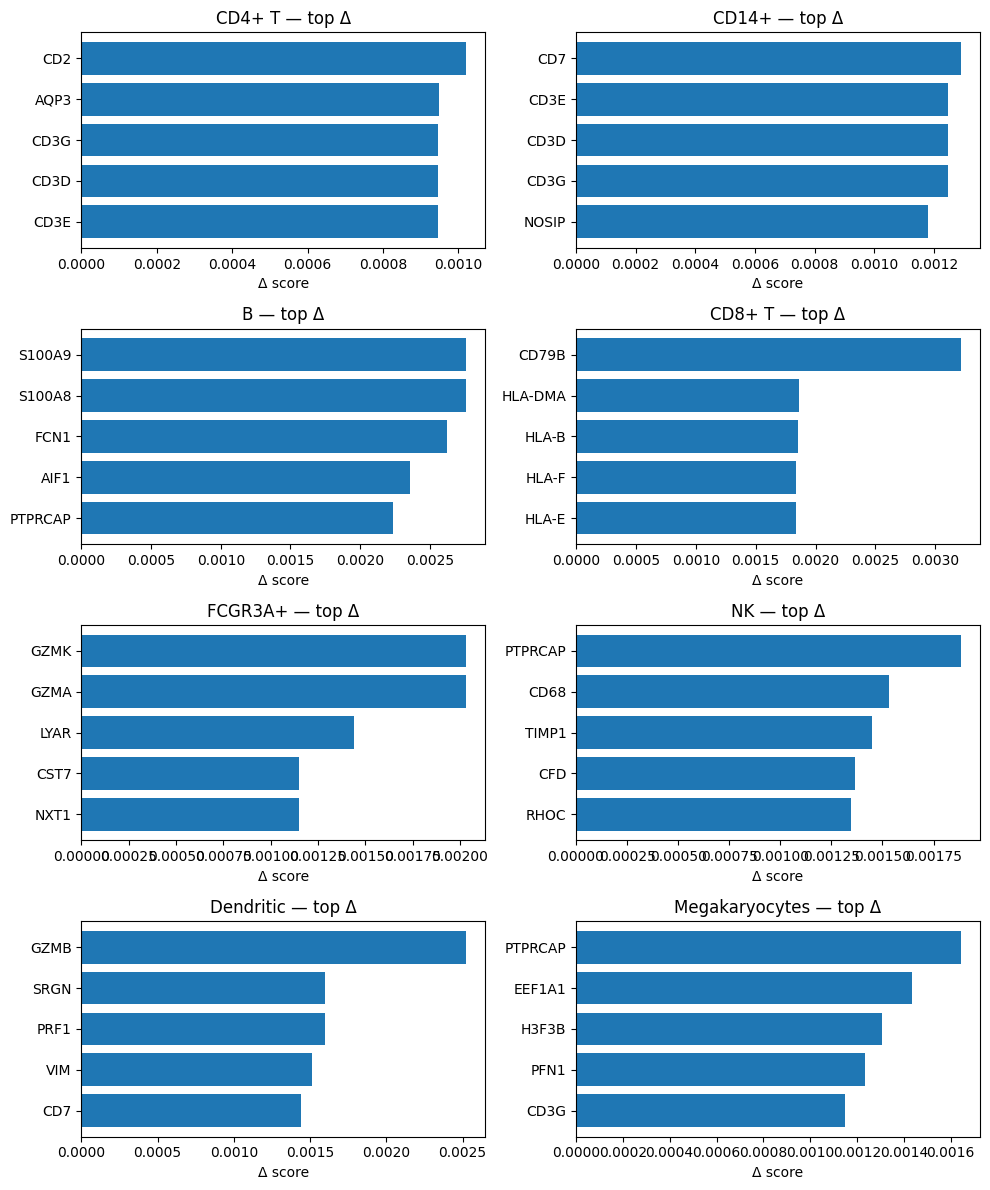

In [ ]:
import matplotlib.pyplot as plt
from math import ceil

# helper to recompute Δ on the intersection universe (using B/adj/deg already built)
def delta_for_cluster(mask_cells):
    B_c, B_r = B[mask_cells], B[~mask_cells]
    k_c    = microarray_shapley(B_c) if B_c.shape[0] else np.zeros(len(genes_use))
    k_rest = microarray_shapley(B_r) if B_r.shape[0] else np.zeros(len(genes_use))
    phi_c  = neighborhood_shapley(k_c)
    phi_r  = neighborhood_shapley(k_rest)
    return np.abs(phi_c - phi_r)

# build per-cluster top5 with scores
perclu = []
for c in sorted(adata.obs['leiden'].unique(), key=lambda x: int(x)):
    mask = (adata.obs['leiden'].values == c)
    delta = delta_for_cluster(mask)
    s = pd.Series(delta, index=genes_use).sort_values(ascending=False).head(5)
    for rank, (g, val) in enumerate(s.items(), start=1):
        perclu.append({'cluster_id': int(c), 'cluster': name_map[str(c)], 'gene': g, 'delta': float(val), 'rank': rank})
df_top5 = pd.DataFrame(perclu)

# multi-panel bar charts
nC = df_top5['cluster'].nunique()
ncols = 2
nrows = ceil(nC / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3*nrows), squeeze=False)
for i, (cluster, sub) in enumerate(df_top5.groupby('cluster', sort=False)):
    ax = axes[i//ncols, i%ncols]
    sub_sorted = sub.sort_values('delta')  # smallest to largest for barh
    ax.barh(sub_sorted['gene'], sub_sorted['delta'])
    ax.set_title(f'{cluster} — top Δ')
    ax.set_xlabel('Δ score')
    ax.set_ylabel('')
plt.tight_layout()
plt.savefig('top5_per_cluster_delta_bars.png', dpi=150)
plt.show()


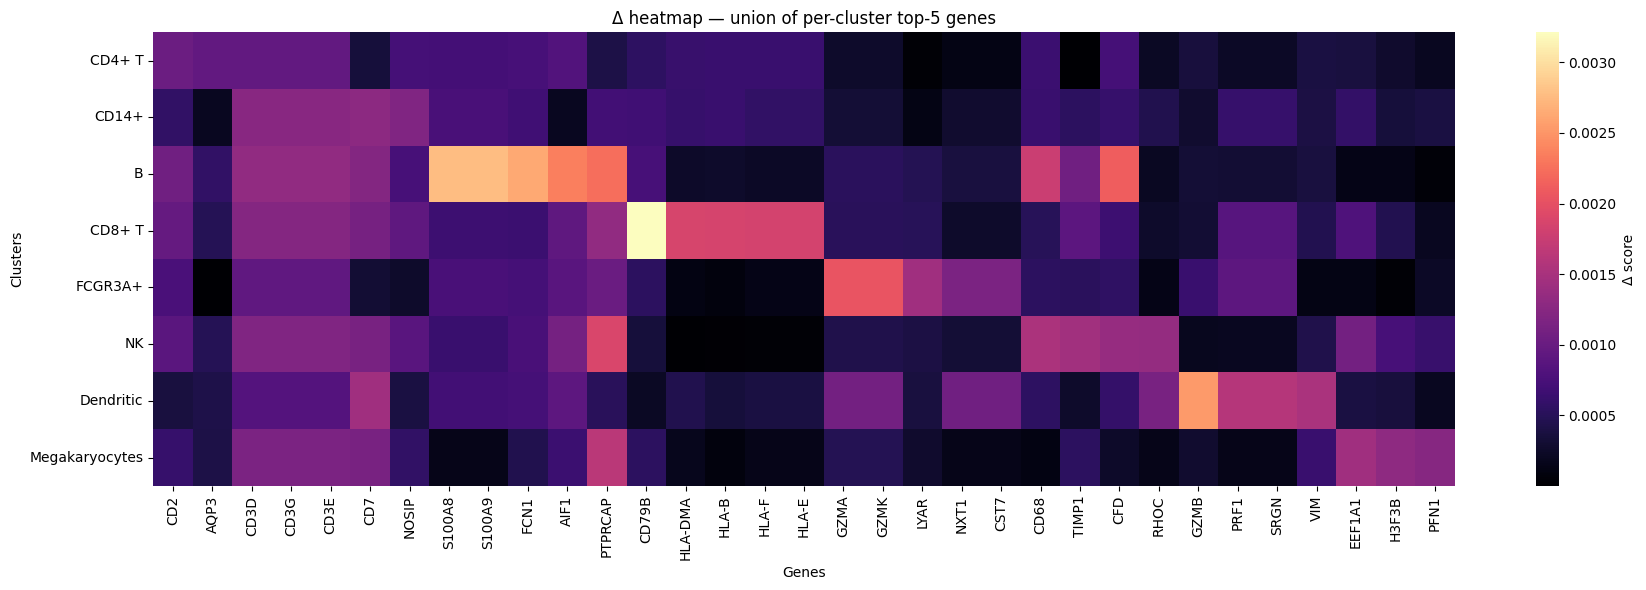

In [ ]:
import seaborn as sns  

# union of all top-5 genes
heat_genes = df_top5['gene'].unique().tolist()

# compute Δ matrix: clusters × genes
clusters_sorted = [name_map[str(i)] for i in sorted(map(int, adata.obs['leiden'].unique()))]
D = []
for c in sorted(map(int, adata.obs['leiden'].unique())):
    mask = (adata.obs['leiden'].values == str(c))
    delta = delta_for_cluster(mask)
    s = pd.Series(delta, index=genes_use)
    D.append(s.reindex(heat_genes).fillna(0.0).values)
D = np.vstack(D)

plt.figure(figsize=(min(18, 0.45*len(heat_genes)+4), 0.5*len(clusters_sorted)+2))
sns.heatmap(D, xticklabels=heat_genes, yticklabels=clusters_sorted, cmap='magma', cbar_kws={'label':'Δ score'})
plt.title('Δ heatmap — union of per-cluster top-5 genes')
plt.xlabel('Genes'); plt.ylabel('Clusters')
plt.tight_layout()
plt.savefig('delta_heatmap_union_top5.png', dpi=150)
plt.show()


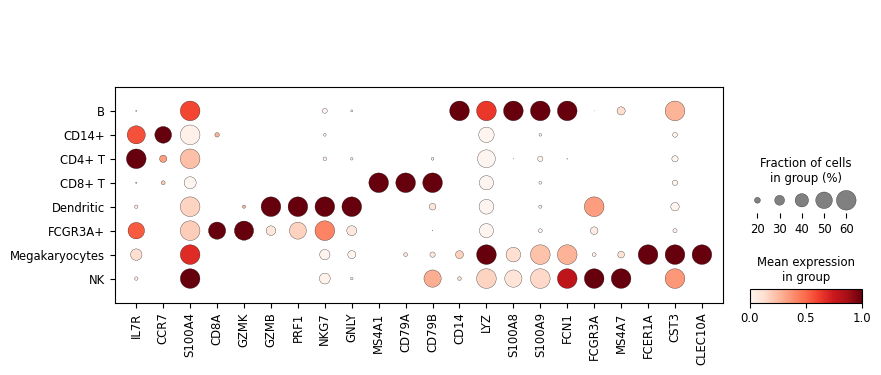

In [ ]:
# Only keep markers that exist in the AnnData
pbmc_panel = [
    ['IL7R','CCR7','S100A4'],                         # CD4 T
    ['CD8A','GZMK','GZMB','PRF1','NKG7','GNLY'],      # CD8/NK
    ['MS4A1','CD79A','CD79B'],                        # B
    ['CD14','LYZ','S100A8','S100A9','FCN1'],          # CD14+ Mono
    ['FCGR3A','MS4A7'],                                # FCGR3A+ Mono
    ['FCER1A','CST3','CLEC10A'],                       # DC
]
panel_flat = [g for row in pbmc_panel for g in row if g in adata.var_names]
if panel_flat:
    sc.pl.dotplot(adata, panel_flat, groupby='cluster_name', standard_scale='var', dot_min=0.1, dot_max=0.6,
                  dendrogram=False, show=True, save='_pbmc_panel.png')


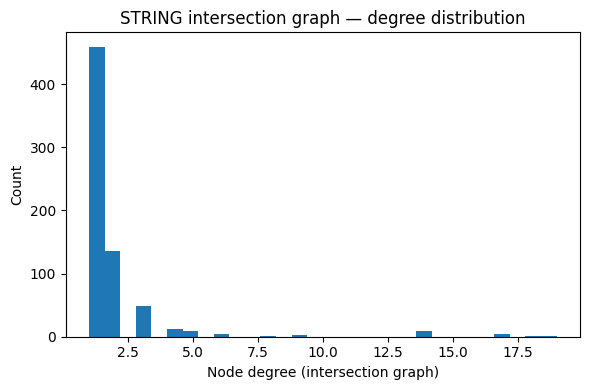

In [9]:
plt.figure(figsize=(6,4))
plt.hist(deg[deg>0], bins=30)
plt.xlabel('Node degree (intersection graph)')
plt.ylabel('Count')
plt.title('STRING intersection graph — degree distribution')
plt.tight_layout()
plt.savefig('ppi_degree_hist.png', dpi=150)
plt.show()


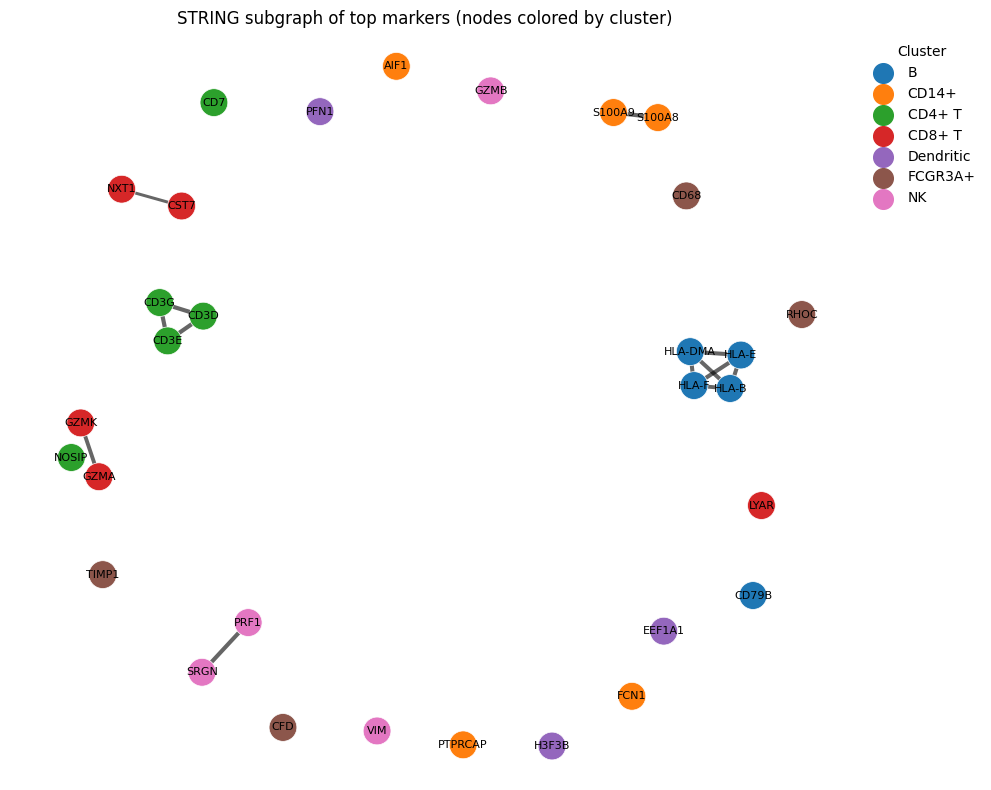

Saved: nx_marker_subgraph.png and nx_cluster_meta_graph.png


In [11]:
# Draw STRING subgraph of top markers
import networkx as nx
from collections import defaultdict

# Collect top markers per cluster from whichever table we have
def get_marker_table():
    if 'df_final' in globals() and {'cluster_consensus','top1','top2','top3','top4','top5'}.issubset(df_final.columns):
        t = df_final.rename(columns={'cluster_consensus':'cluster'}).copy()
    elif 'df_named' in globals() and {'cluster','top1','top2','top3','top4','top5'}.issubset(df_named.columns):
        t = df_named.copy()
    elif 'df_wide' in globals() and {'cluster','top1','top2','top3','top4','top5'}.issubset(df_wide.columns):
        t = df_wide.copy()
    else:
        raise RuntimeError("Need df_final or df_named or df_wide with columns: cluster, top1..top5.")
   
    for c in ['cluster','top1','top2','top3','top4','top5']:
        t[c] = t[c].astype(str).str.strip()
    return t

tbl = get_marker_table()

# dict: cluster to list of marker genes (uppercased to match ppi normalization)
cluster_to_genes = {row['cluster']: [str(row[f'top{i}']).upper() for i in range(1,6)] 
                    for _, row in tbl.iterrows()}
all_markers = sorted({g for L in cluster_to_genes.values() for g in L})

# Build the STRING subgraph for those markers
if not {'geneA','geneB'}.issubset(ppi.columns):
    raise RuntimeError("ppi must have columns 'geneA','geneB' (and optional 'score').")

ppi_sub = ppi.copy()
ppi_sub['geneA'] = ppi_sub['geneA'].astype(str).str.upper().str.strip()
ppi_sub['geneB'] = ppi_sub['geneB'].astype(str).str.upper().str.strip()

# keep only marker-marker edges; optional score threshold if present
if 'score' in ppi_sub.columns:
    SCORE_MIN = 0.0    # set to 0.4–0.6 if you want a tighter graph
    ppi_sub = ppi_sub[ppi_sub['score'] >= SCORE_MIN]

ppi_sub = ppi_sub[ppi_sub['geneA'].isin(all_markers) & ppi_sub['geneB'].isin(all_markers)]
ppi_sub = ppi_sub[ppi_sub['geneA'] != ppi_sub['geneB']].drop_duplicates()

# 2) Build the networkx graph, annotate cluster for each node
G = nx.Graph()
#  (if a gene appears in multiple cluster lists, keep the first seen)
gene_to_cluster = {}
for cl, genes in cluster_to_genes.items():
    for g in genes:
        gene_to_cluster.setdefault(g, cl)

for g in all_markers:
    G.add_node(g, cluster=gene_to_cluster.get(g, 'Unknown'))

for a,b,s in ppi_sub[['geneA','geneB','score']].itertuples(index=False):
    G.add_edge(a, b, weight=float(s) if 'score' in ppi_sub.columns else 1.0)

# Pick colors per cluster
clusters_sorted = sorted(cluster_to_genes.keys())
palette = plt.cm.tab10.colors if len(clusters_sorted) <= 10 else plt.cm.tab20.colors
color_map = {cl: palette[i % len(palette)] for i, cl in enumerate(clusters_sorted)}
node_colors = [color_map[G.nodes[n]['cluster']] for n in G.nodes()]

#  Plot: gene–gene network (spring layout on the marker subgraph)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.35)  # k controls spacing
nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors, linewidths=0.5, edgecolors='white')
nx.draw_networkx_edges(G, pos, width=[0.5 + 2.5*G.edges[e]['weight'] for e in G.edges()] if 'score' in ppi_sub.columns else 1.0, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

for i, cl in enumerate(clusters_sorted):
    plt.scatter([], [], c=[color_map[cl]], s=200, label=cl)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, title='Cluster')
plt.title('STRING subgraph of top markers (nodes colored by cluster)')
plt.axis('off')
plt.tight_layout()
plt.savefig('nx_marker_subgraph.png', dpi=150)
plt.show()


print("Saved: nx_marker_subgraph.png and nx_cluster_meta_graph.png")
